In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

plt.style.use('dark_background')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv

/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv

/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv

/kaggle/input/store-sales-time-series-forecasting/stores.csv

/kaggle/input/store-sales-time-series-forecasting/train.csv

/kaggle/input/store-sales-time-series-forecasting/test.csv

/kaggle/input/store-sales-time-series-forecasting/transactions.csv


## **Importing Data**

In [2]:
BASE = '/kaggle/input/store-sales-time-series-forecasting/'

train = pd.read_csv(BASE + "train.csv")
test = pd.read_csv(BASE + "test.csv")
oil = pd.read_csv(BASE + "oil.csv")
stores = pd.read_csv(BASE + "stores.csv")
transactions = pd.read_csv(BASE + "transactions.csv")
holidays_events = pd.read_csv(BASE + "holidays_events.csv")
sample_submission = pd.read_csv(BASE + "sample_submission.csv")


In [3]:
test['test'] = 1
train['test'] = 0
df = pd.concat([train, test], axis=0)

In [4]:
df

,id,date,store_nbr,family,sales,onpromotion,test
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0
...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,1
28509,3029397,2017-08-31,9,PRODUCE,NaN,1,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,1


In [5]:
df.isna().mean()

id             0.000000
date           0.000000
store_nbr      0.000000
family         0.000000
sales          0.009412
onpromotion    0.000000
test           0.000000
dtype: float64

In [6]:
df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
test             int64
dtype: object

## **Data analysis and vizualization**

In [7]:
def datetime(df):
    df['date'] = pd.to_datetime(df["date"])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_name'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    df['is_leap_year'] = df['date'].dt.is_leap_year
    return df

In [8]:
df = datetime(df)

In [9]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,test,year,month,day,day_of_week,day_name,quarter,is_leap_year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,2013,1,1,1,Tuesday,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,0,2013,1,1,1,Tuesday,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,0,2013,1,1,1,Tuesday,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,2013,1,1,1,Tuesday,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,0,2013,1,1,1,Tuesday,1,False


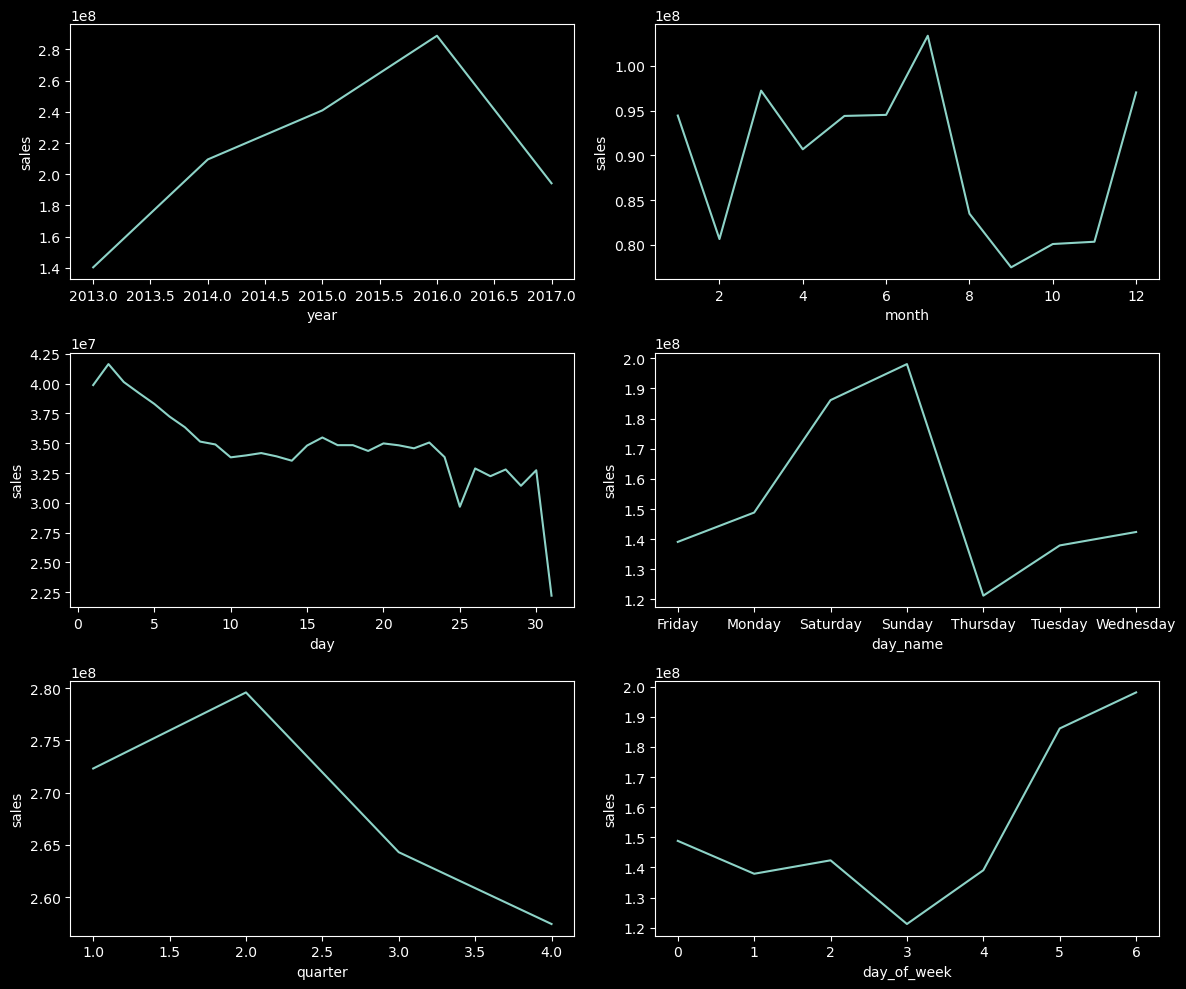

In [10]:
grouping_columns = ['year', 'month', 'day', 'day_name', 'quarter', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ind, column in enumerate(grouping_columns):
    grouped_data = df.groupby(column)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

    sns.lineplot(data=grouped_data, x=column, y='sales', ax=axes[ind])

plt.tight_layout()
plt.show()

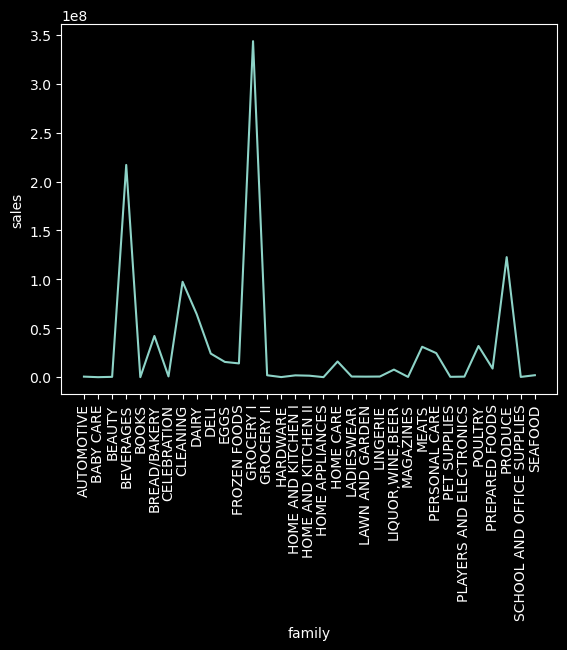

In [11]:
grouped_data = df.groupby('family')['sales'].sum().reset_index()

sns.lineplot(data=grouped_data, x='family', y='sales')

ax = plt.gca()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [12]:
pd.DataFrame(df.groupby('year')['sales'].sum()).reset_index().sort_values(by='sales', ascending=False)

,year,sales
3,2016,2.886545e+08
2,2015,2.408801e+08
1,2014,2.094742e+08
4,2017,1.942171e+08
0,2013,1.404190e+08


<Axes: xlabel='store_nbr', ylabel='sales'>

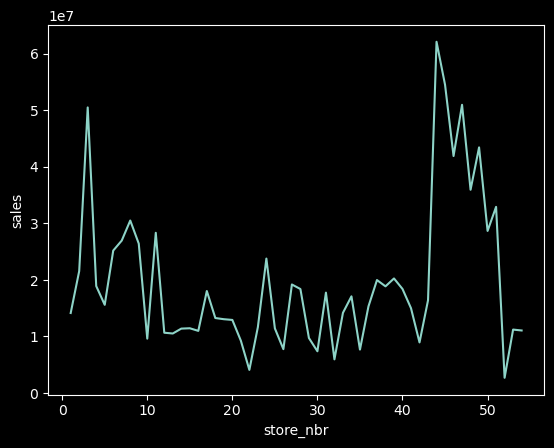

In [13]:
best_store = df.groupby('store_nbr')['sales'].sum().reset_index()

bs_sorted = best_store.sort_values(by='sales', ascending=False)

sns.lineplot(data=bs_sorted, x='store_nbr', y='sales')

In [14]:
best_city = pd.merge(bs_sorted, stores, on='store_nbr', how='left')

best_city['ratio'] = 0

for city in best_city['city'].unique():
    ratio = len(best_city.loc[best_city['city'] == city]) / len(best_city)
    best_city.loc[best_city['city'] == city, 'ratio'] = ratio

best_city.head()

,store_nbr,sales,city,state,type,cluster,ratio
0,44,6.208755e+07,Quito,Pichincha,A,5,0.333333
1,45,5.449801e+07,Quito,Pichincha,A,11,0.333333
2,47,5.094831e+07,Quito,Pichincha,A,14,0.333333
3,3,5.048191e+07,Quito,Pichincha,D,8,0.333333
4,49,4.342010e+07,Quito,Pichincha,A,11,0.333333


In [15]:
best_city.sort_values(by='sales', ascending=True).head()

,store_nbr,sales,city,state,type,cluster,ratio
53,52,2.696170e+06,Manta,Manabi,A,11,0.037037
52,22,4.090202e+06,Puyo,Pastaza,C,7,0.018519
51,32,5.951796e+06,Guayaquil,Guayas,C,3,0.148148
50,30,7.382074e+06,Guayaquil,Guayas,C,3,0.148148
49,35,7.676679e+06,Playas,Guayas,C,3,0.018519


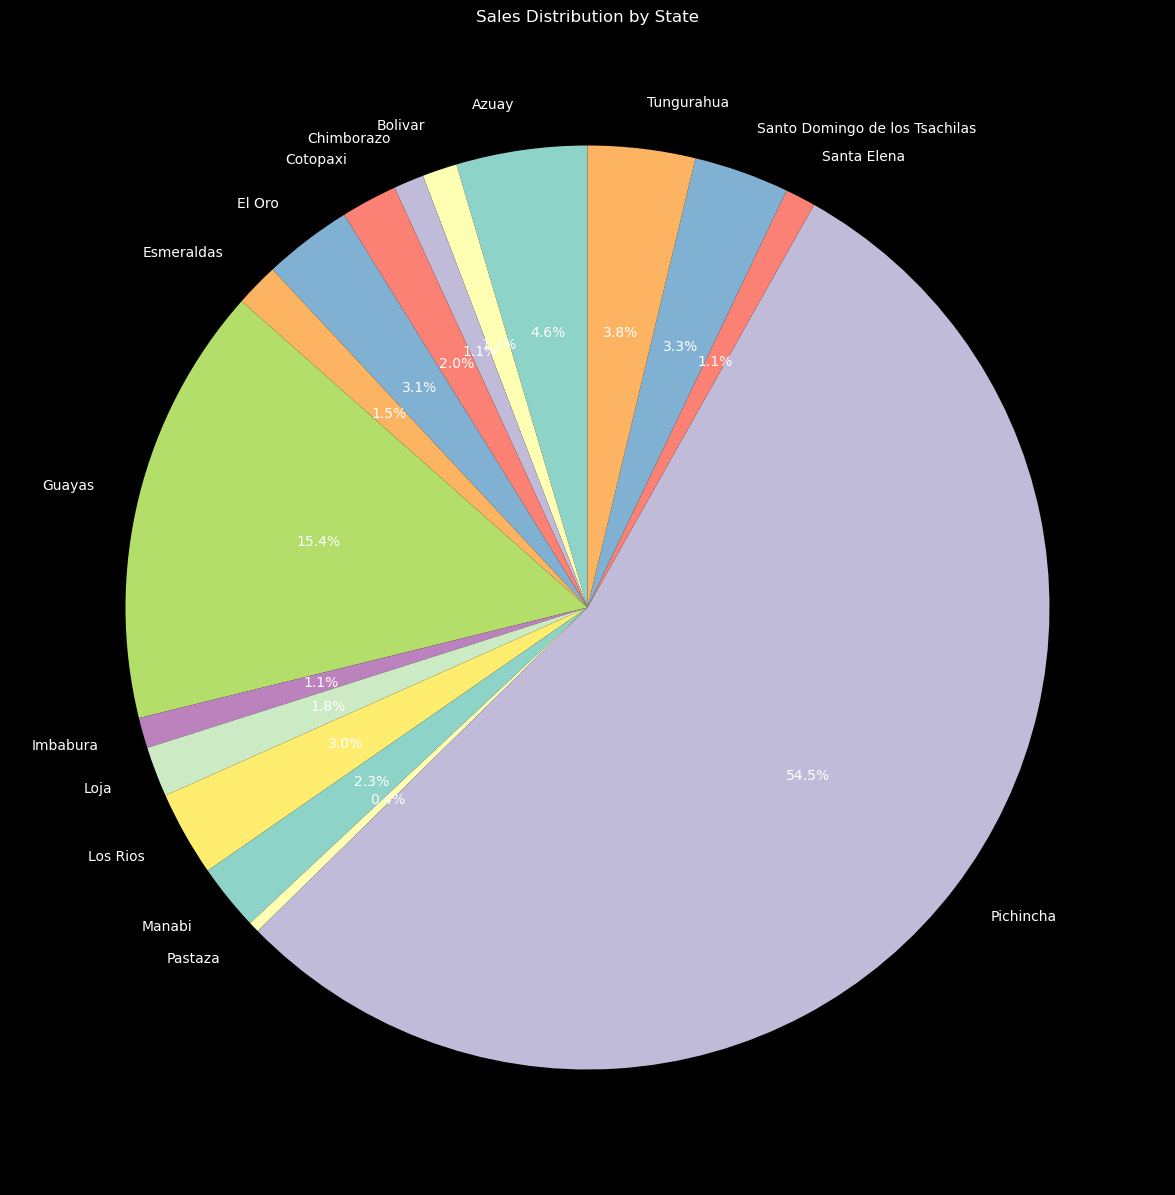

In [16]:
data = best_city.groupby('state')['sales'].sum()

plt.figure(figsize=(15, 15))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)

plt.title('Sales Distribution by State')

plt.show()

In [17]:
best_city.groupby('city')['ratio'].apply(lambda x: x[0:1])/best_city.groupby('city')['sales'].sum()

city             
Ambato         9     9.189328e-10
Babahoyo       24    1.043481e-09
Cayambe        10    6.537742e-10
Cuenca         16    1.129899e-09
Daule          18    9.651083e-10
El Carmen      40    1.674750e-09
Esmeraldas     26    1.129750e-09
Guaranda       33    1.419097e-09
Guayaquil      7     1.204777e-09
Ibarra         36    1.617158e-09
Latacunga      42    1.748493e-09
Libertad       28    1.208589e-09
Loja           20    9.818939e-10
Machala        21    1.109332e-09
Manta          39    2.662172e-09
Playas         49    2.412308e-09
Puyo           52    4.527532e-09
Quevedo        30    1.306098e-09
Quito          0     5.987215e-10
Riobamba       38    1.626155e-09
Salinas        37    1.621445e-09
Santo Domingo  27    1.550345e-09
dtype: float64

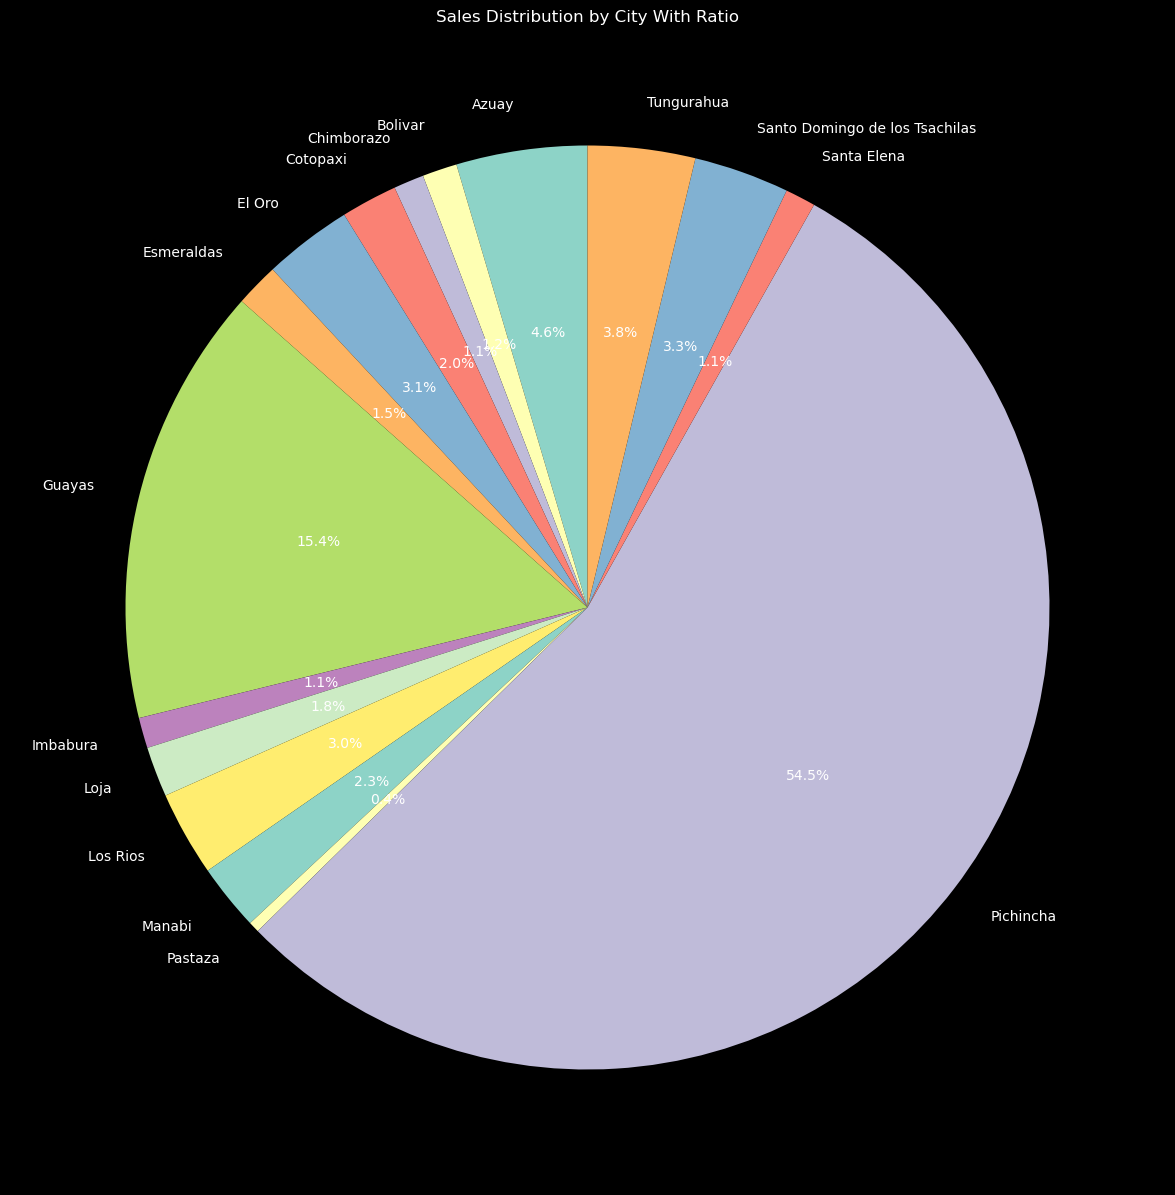

In [18]:
best_city.groupby('city')['ratio'].apply(lambda x: x[0:1])/best_city.groupby('city')['sales'].sum()

plt.figure(figsize=(15, 15))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)

plt.title('Sales Distribution by City With Ratio')

plt.show()

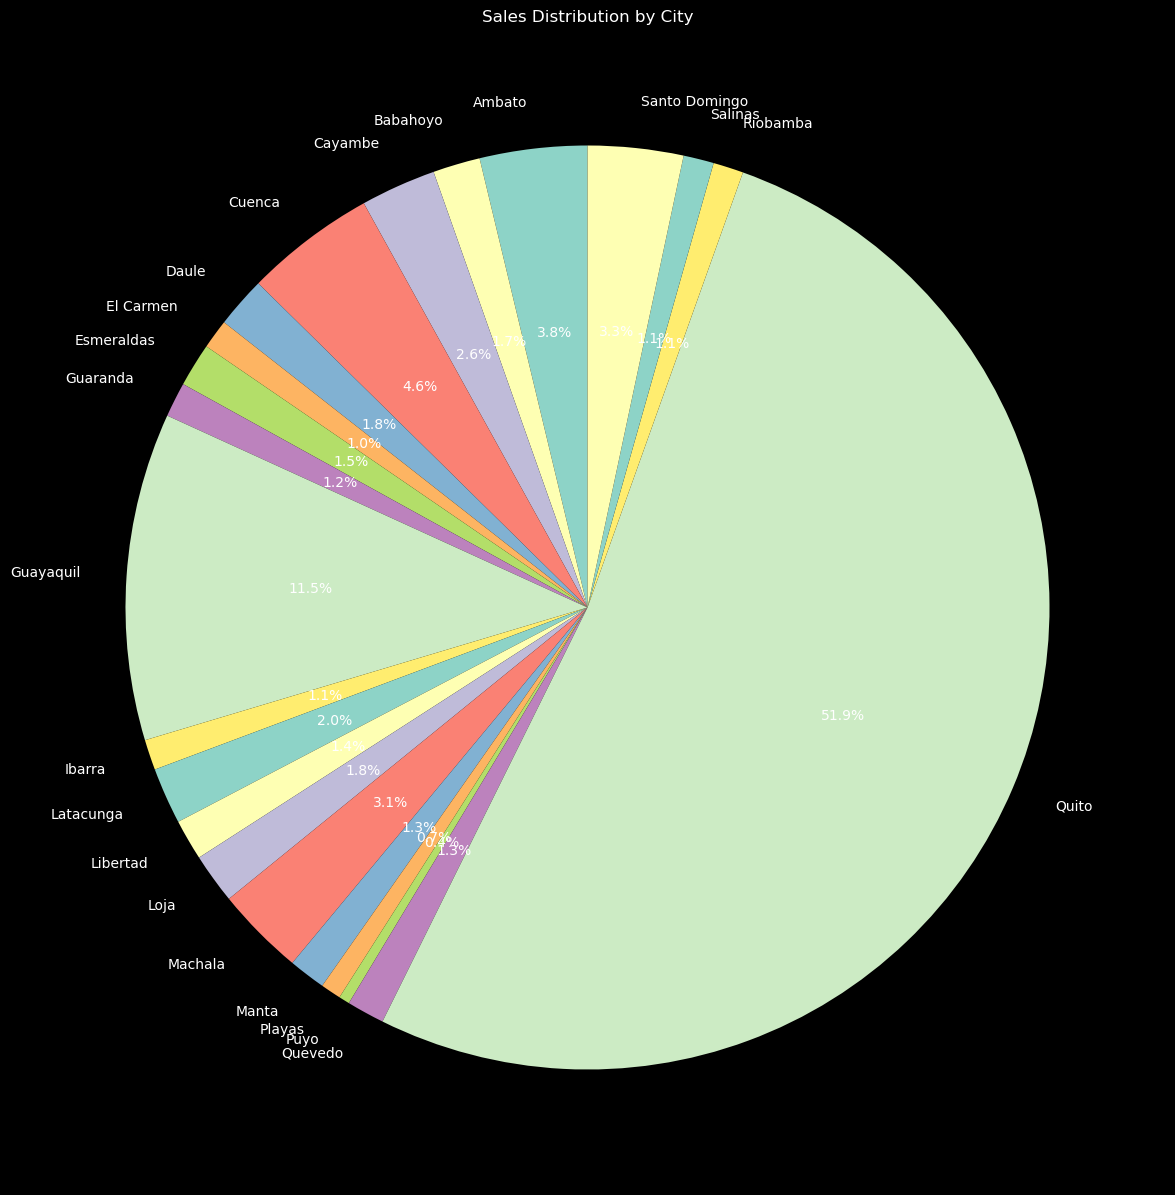

In [19]:
data = best_city.groupby('city')['sales'].sum()

plt.figure(figsize=(15, 15))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)

plt.title('Sales Distribution by City')

plt.show()

In [20]:
df = pd.merge(df, stores, how='left', on='store_nbr')

In [21]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,test,year,month,day,day_of_week,day_name,quarter,is_leap_year,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,0,2013,1,1,1,Tuesday,1,False,Quito,Pichincha,D,13


In [22]:
pd.DataFrame(df.groupby('cluster')['sales'].sum()).reset_index().sort_values(by='sales', ascending=True).head(10)

,cluster,sales
15,16,1.325938e+07
6,7,1.547812e+07
11,12,1.803097e+07
1,2,2.891640e+07
8,9,3.056108e+07
16,17,3.291149e+07
3,4,4.944344e+07
0,1,5.437675e+07
14,15,5.529695e+07
4,5,6.208755e+07


In [23]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [24]:
holidays_events['date'] = pd.to_datetime(holidays_events["date"])
df = pd.merge(df, holidays_events, how='left', on='date')

In [25]:
df_non_nan = df.dropna(subset=['locale'])
df_non_nan.head()

,id,date,store_nbr,family,sales,onpromotion,test,year,month,day,...,is_leap_year,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,2013,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,0,2013,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,0,2013,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,2013,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,0,2013,1,1,...,False,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [26]:
df_non_nan['type_y'].value_counts()

Holiday       306504
Event          99792
Additional     67716
Transfer       16038
Work Day        8910
Bridge          5346
Name: type_y, dtype: int64

In [27]:
df_non_nan['locale'].value_counts()

National    261954
Local       210276
Regional     32076
Name: locale, dtype: int64

In [28]:
df_non_nan.groupby(['type_y', 'family'])['sales'].sum()

type_y      family                    
Additional  AUTOMOTIVE                    1.496400e+04
            BABY CARE                     3.050000e+02
            BEAUTY                        9.801000e+03
            BEVERAGES                     6.183568e+06
            BOOKS                         3.100000e+02
                                              ...     
Work Day    POULTRY                       9.566624e+04
            PREPARED FOODS                2.989535e+04
            PRODUCE                       2.425016e+05
            SCHOOL AND OFFICE SUPPLIES    1.520000e+02
            SEAFOOD                       6.645205e+03
Name: sales, Length: 198, dtype: float64

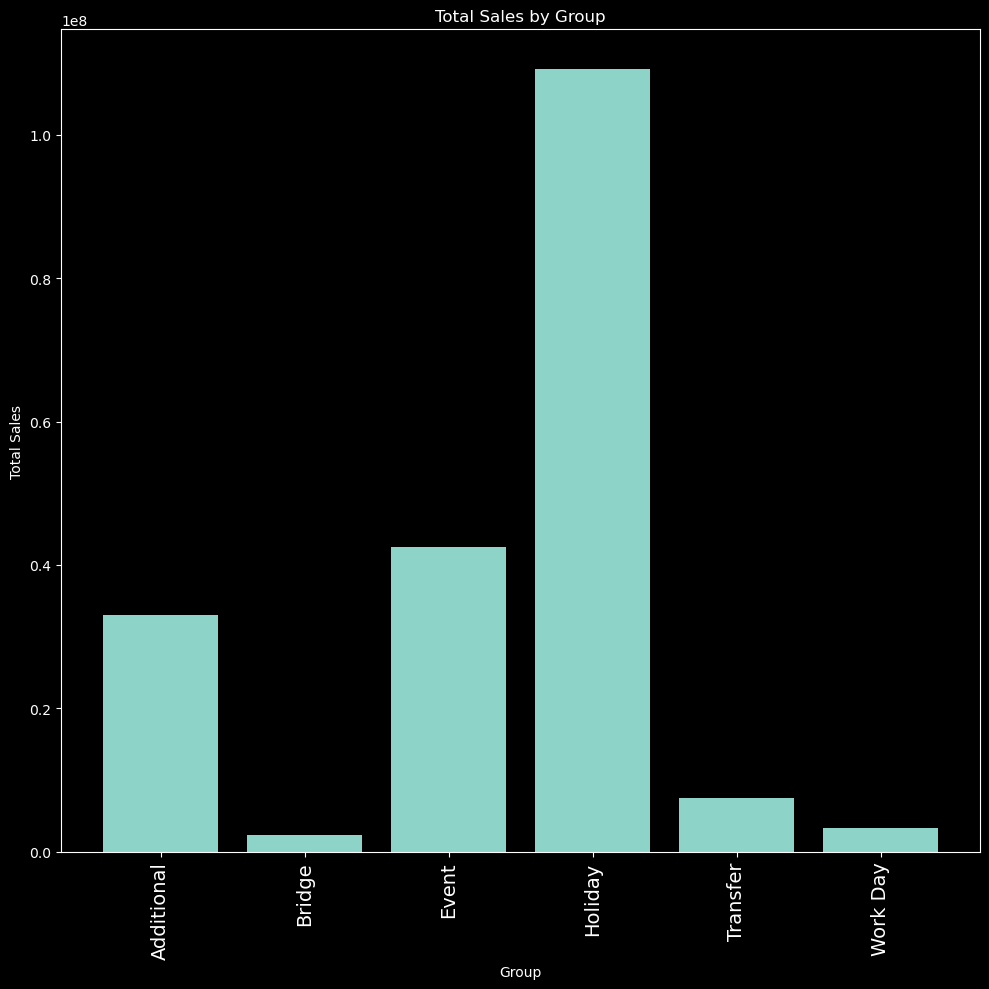

In [29]:
grouped_data = df_non_nan.groupby(['type_y'])['sales'].sum()

grouped_data = grouped_data.reset_index()

plt.figure(figsize=(10, 10))
plt.bar(range(len(grouped_data)), grouped_data['sales'])
plt.xlabel('Group')
plt.ylabel('Total Sales')
plt.title('Total Sales by Group')
plt.xticks(range(len(grouped_data)), grouped_data['type_y'], rotation=90, fontsize=14)
plt.tight_layout()
plt.show()

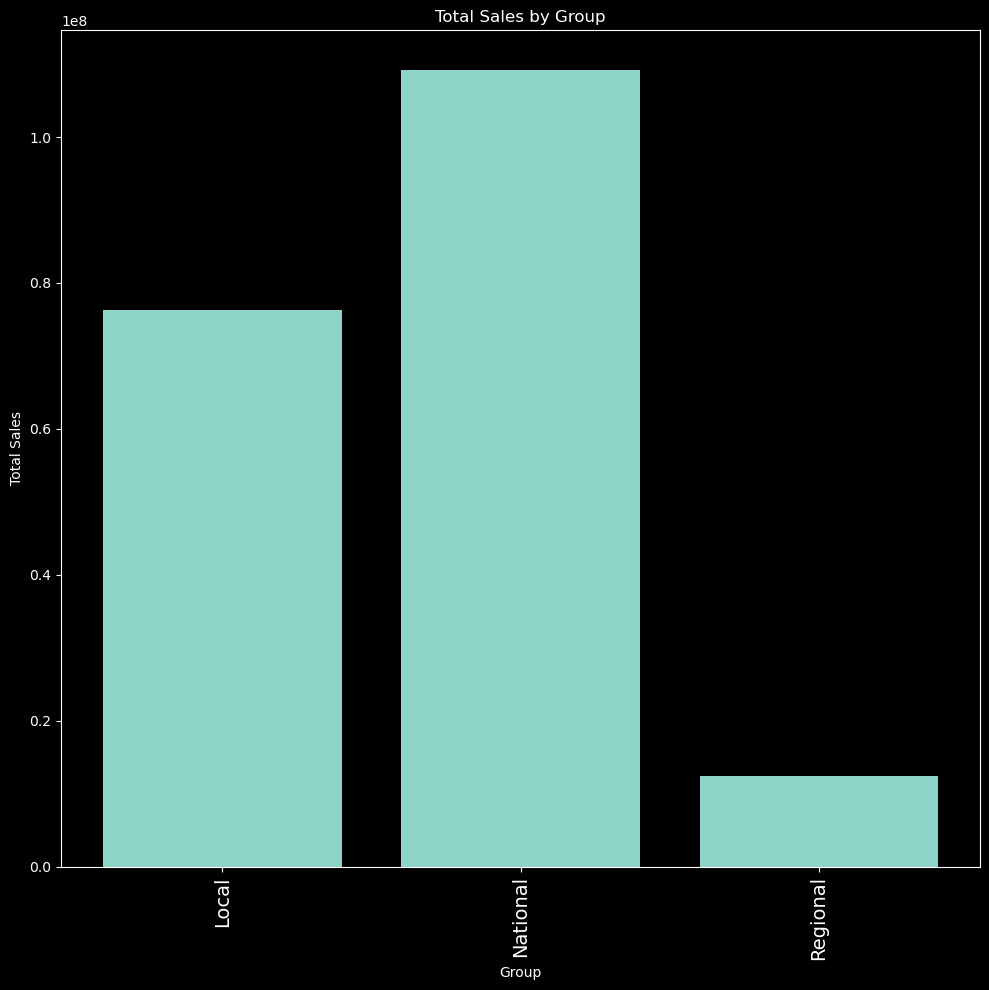

In [30]:
grouped_data = df_non_nan.groupby(['locale'])['sales'].sum()

grouped_data = grouped_data.reset_index()

plt.figure(figsize=(10, 10))
plt.bar(range(len(grouped_data)), grouped_data['sales'])
plt.xlabel('Group')
plt.ylabel('Total Sales')
plt.title('Total Sales by Group')
plt.xticks(range(len(grouped_data)), grouped_data['locale'], rotation=90, fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
df_non_nan[df_non_nan['transferred'] == True].groupby('locale')['sales'].sum()

locale
Local       1.489146e+06
National    3.507657e+06
Name: sales, dtype: float64

## **Feature Engineering**

In [32]:
df['type_y'] = df['type_y'].fillna(0)

df['transferred'] = df['transferred'].fillna(0.0).astype(float)

df['locale'] = df['locale'].fillna(0)

categorical_features = ['family', 'day_name', 'city', 'state', 'type_x', 'transferred', 'locale', 'type_y']

df = pd.get_dummies(df, columns=categorical_features)

df['is_leap_year'] = df['is_leap_year'].astype(int)

In [33]:
df.head()

,id,date,store_nbr,sales,onpromotion,test,year,month,day,day_of_week,...,locale_Local,locale_National,locale_Regional,type_y_0,type_y_Additional,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day
0,0,2013-01-01,1,0.0,0,0,2013,1,1,1,...,0,1,0,0,0,0,0,1,0,0
1,1,2013-01-01,1,0.0,0,0,2013,1,1,1,...,0,1,0,0,0,0,0,1,0,0
2,2,2013-01-01,1,0.0,0,0,2013,1,1,1,...,0,1,0,0,0,0,0,1,0,0
3,3,2013-01-01,1,0.0,0,0,2013,1,1,1,...,0,1,0,0,0,0,0,1,0,0
4,4,2013-01-01,1,0.0,0,0,2013,1,1,1,...,0,1,0,0,0,0,0,1,0,0


In [34]:
from sklearn.decomposition import PCA


encoded_cities = [
'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 
'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala', 'city_Manta', 'city_Playas',
'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
'state_Azuay', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas',
'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_Los Rios', 'state_Manabi', 'state_Pastaza',
'state_Pichincha', 'state_Santa Elena', 'state_Santo Domingo de los Tsachilas', 'state_Tungurahua'
]

num_components = 5
pca_model = PCA(n_components=num_components)

pca_model.fit(df[encoded_cities])

transformed_data = pca_model.transform(df[encoded_cities])

cols = [f'place_pca_{i}' for i in range(1, 6)]

df.drop(columns = encoded_cities)

df[cols] = transformed_data

## **BaseModel**

In [35]:
df.columns

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'test', 'year',
       'month', 'day', 'day_of_week',
       ...
       'type_y_Bridge', 'type_y_Event', 'type_y_Holiday', 'type_y_Transfer',
       'type_y_Work Day', 'place_pca_1', 'place_pca_2', 'place_pca_3',
       'place_pca_4', 'place_pca_5'],
      dtype='object', length=116)

In [36]:
features = [
'store_nbr', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'quarter', 'is_leap_year', 
'cluster', 'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES', 'family_MEATS',
'family_PERSONAL CARE', 'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
'family_PREPARED FOODS', 'family_PRODUCE', 'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD',
'place_pca_1', 'place_pca_2', 'place_pca_3',
'place_pca_4', 'place_pca_5', 'type_x_A', 'type_x_B', 'type_x_C', 'type_x_D', 
'type_x_E', 'transferred_0.0', 'transferred_1.0','locale_0', 'locale_Local', 
'locale_National', 'locale_Regional', 'type_y_0', 'type_y_Additional',
'type_y_Bridge', 'type_y_Event', 'type_y_Holiday', 'type_y_Transfer', 'type_y_Work Day'
]

target = 'sales'

In [37]:
from sklearn.model_selection import train_test_split

df_pl = pl.DataFrame(df)

train = df_pl.filter(pl.col('test') == 0)
test = df_pl.filter(pl.col('test') == 1)

train = train.to_pandas()
test = test.to_pandas()

X_train, X_test, y_train, y_test = train.loc[train['year'] != 2017][features], train.loc[train['year'] == 2017][features], train.loc[train['year'] != 2017][target],train.loc[train['year'] == 2017][target]                                 

In [38]:
from xgboost import XGBRegressor
import catboost as cb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

scaler = StandardScaler()

model_cb = cb.CatBoostRegressor(verbose=False)
model_xgb = XGBRegressor(verbosity=0)

pipeline_cb = Pipeline([
    ('scaler', scaler),
    ('model_cb', model_cb) 
])

pipeline_xgb = Pipeline([
    ('scaler', scaler), 
    ('model_xgb', model_xgb)
])

pipeline_cb.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)

y_pred_cb = pipeline_cb.predict(X_test)
y_pred_xgb = pipeline_xgb.predict(X_test)

y_pred_combined = 0.5 * y_pred_cb + 0.5 * y_pred_xgb

msle = mean_squared_log_error(abs(y_test), abs(y_pred_combined), squared=False)
print("Mean Squared Log Error:", msle)

Mean Squared Log Error: 1.5185607313111775


## **Submission**

In [39]:
sample_submission['sales'] = 0.5 * pipeline_cb.predict(test[features]) + 0.5 * pipeline_xgb.predict(test[features]) 

In [40]:
sample_submission

,id,sales
0,3000888,10.243918
1,3000889,7.942912
2,3000890,-44.276156
3,3000891,1873.011743
4,3000892,7.500425
...,...,...
28507,3029395,407.426240
28508,3029396,70.370597
28509,3029397,1281.601624
28510,3029398,117.120863


In [41]:
sample_submission.to_csv('submission.csv', index=False)